<a href="https://colab.research.google.com/github/timescast/DL/blob/main/DL_02_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces","/content/drive/MyDrive/pytorch_files")

In [ ]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

In [ ]:
image_path = []
label = []
pathr = "/content/drive/MyDrive/pytorch_files/animal-faces/afhq/"
for i in os.listdir(pathr):
  for j in os.listdir(pathr+i):
    for k in os.listdir(pathr+i+"/"+j):
      image_path.append(pathr+i+"/"+j+"/"+k)
      label.append(j)
data_df = pd.DataFrame()
data_df["image_path"] = image_path
data_df["label"] = label

In [ ]:
data_df['label'].unique()

array(['cat', 'dog', 'wild'], dtype=object)

In [ ]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

In [ ]:
val = test.sample(frac=0.5)
test = test.drop(val.index)

In [ ]:
print(val.shape,test.shape,train.shape)

(2420, 2) (2419, 2) (11291, 2)


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['label'])

LabelEncoder()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)])

In [ ]:
class CustomeDataset(Dataset):
  def __init__(self,dataframe,transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.label = torch.tensor(label_encoder.transform(dataframe['label']))
  def __len__(self):
    return self.dataframe.shape[0]
  def __getitem__(self,idx):
    image_path = self.dataframe.iloc[idx,0]
    label = self.label[idx]
    image = Image.open(image_path).convert("RGB")
    if self.transform:
      image = self.transform(image)
    return image,label

In [ ]:
train_dataset = CustomeDataset(train,transform)
val_dataset = CustomeDataset(val,transform)
test_dataset = CustomeDataset(test,transform)

In [ ]:
len(train_dataset),len(val_dataset),len(test_dataset)

(11291, 2420, 2419)

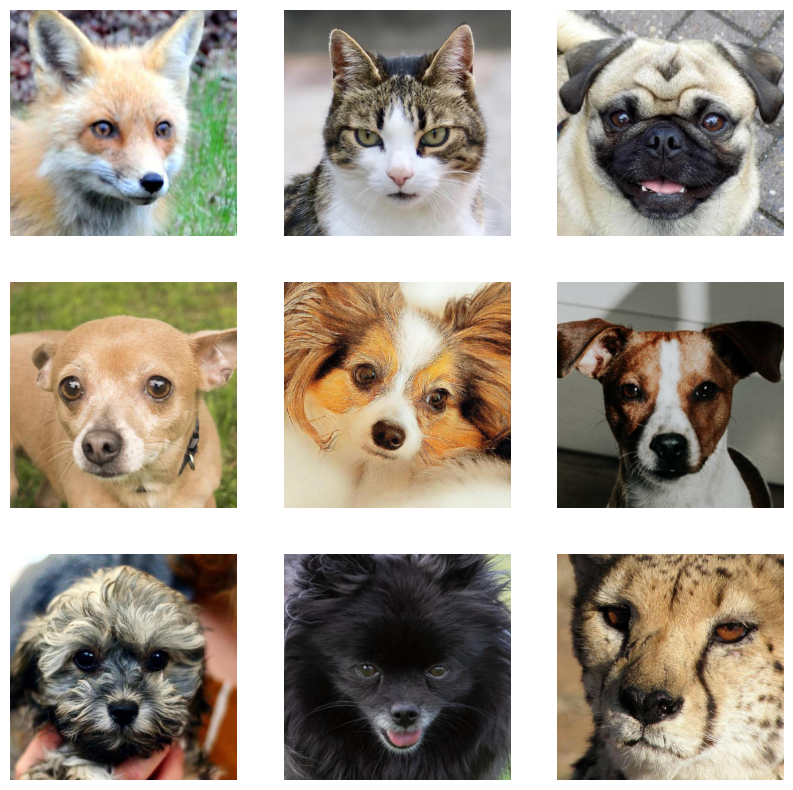

In [ ]:
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)['image_path'].iloc[0]).convert("RGB")
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

In [ ]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(3,32,3,padding=1)
    self.conv2 = nn.Conv2d(32,64,3,padding=1)
    self.conv3 = nn.Conv2d(64,128,3,padding=1)

    self.pool = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128 * 16 * 16), 128)
    self.output = nn.Linear(128,len(data_df['label'].unique()))
  def forward(self,x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv3(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)
    return x



In [ ]:
model = Net()

In [ ]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=LR)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 3.1391 Train Accuracy 81.596
              Validation Loss: 0.3925 Validation Accuracy: 90.2066
Epoch 2/10, Train Loss: 1.3524 Train Accuracy 93.083
              Validation Loss: 0.2396 Validation Accuracy: 94.3388
Epoch 3/10, Train Loss: 0.8587 Train Accuracy 95.5894
              Validation Loss: 0.2026 Validation Accuracy: 95.7025
Epoch 4/10, Train Loss: 0.6142 Train Accuracy 96.7851
              Validation Loss: 0.2148 Validation Accuracy: 95.3719
Epoch 5/10, Train Loss: 0.4253 Train Accuracy 97.8301
              Validation Loss: 0.179 Validation Accuracy: 96.157
Epoch 6/10, Train Loss: 0.3286 Train Accuracy 98.2021
              Validation Loss: 0.21 Validation Accuracy: 95.124
Epoch 7/10, Train Loss: 0.2489 Train Accuracy 98.8132
              Validation Loss: 0.2062 Validation Accuracy: 95.7851
Epoch 8/10, Train Loss: 0.1968 Train Accuracy 99.0435
              Validation Loss: 0.1959 Validation Accuracy: 96.4876
